In [20]:
#import all relevant packages

import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
#import and read the dataset
#os.chdir("/clean_BNPL_clients.csv")

bnpl = pd.read_csv('clean_BNPL_python.csv')

#define a function to convert category features into numerical

def encode_categoricals(df, categorical_features):
  for col in categorical_features:
    df[col] = df[col].astype("category").cat.codes
  return df

#identify the numerical categories

bnpl_continuous = bnpl[['loan_amnt', 'int_rate', 'monthly_payment', 'annual_inc', 'total_dti', 'tot_coll_amt', 'tot_cur_bal', \
                                  'total_bal_ex_mort','credit_limit']]

#identify categorical categories

bnpl_categor = bnpl[['loan_term', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_purpose', \
                               'delinq_2yrs', 'open_acc','addr_state', 'application_type', 'cur_acct_delinq', 'mort_acc', \
                               'num_accts_120_pd', 'pub_rec_bankruptcies', 'tax_liens', 'hardship_flag', 'disbursement_method', \
                               'debt_settlement_flag']]
#source the column indices
bnpl_categor_indx = [bnpl.columns.get_loc(col) for col in bnpl_categor]

#use the encoding function to convert the string variables into numerical

bnpl_num = encode_categoricals(bnpl, bnpl_categor)

#enact one-hot encoding
bnpl_num = pd.get_dummies(bnpl_num, columns=bnpl_categor.columns,
                          prefix = bnpl_categor.columns)

#split the data into training and test sets

bnpl_att = bnpl_num.drop(['loan_status'], axis=1)
bnpl_tar = bnpl_num['loan_status']

from sklearn.model_selection import train_test_split

bnpl_att_train, bnpl_att_test, bnpl_tar_train, bnpl_tar_test = train_test_split(bnpl_att, bnpl_tar, test_size=0.3, random_state=55)

#resample the data with SMOTE, which will go on to be used in the models

from imblearn.over_sampling import SMOTE
bnpl_smote = SMOTE(random_state=1000)

bnpl_train_att_resample, bnpl_train_tar_resample = bnpl_smote.fit_resample(bnpl_att_train, bnpl_tar_train)

#resample the data with k-means SMOTE methods

from imblearn.over_sampling import KMeansSMOTE
bnpl_KMsmote = KMeansSMOTE(random_state=1000, cluster_balance_threshold=0.1, kmeans_estimator=30)

bnpl_train_att_KM_resample, bnpl_train_tar_KM_resample = bnpl_KMsmote.fit_resample(bnpl_att_train, bnpl_tar_train)

In [22]:
#build a random forest model
#for SMOTE resampling

bnpl_rf = RandomForestClassifier(max_features=50, max_depth=5, random_state=0, n_estimators=100)

bnpl_rf.fit(bnpl_train_att_resample, bnpl_train_tar_resample)
bnpl_rf.predict(bnpl_train_att_resample)
print("Accuracy:", bnpl_rf.score(bnpl_att_test, bnpl_tar_test))

Accuracy: 0.8307179950327388


array([[32443,  5595],
       [ 5329, 32709]])

<Figure size 18000x18000 with 0 Axes>

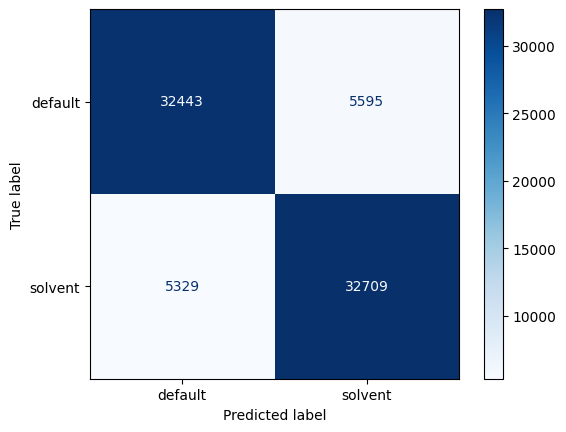

In [23]:
#develop a graphic to plot random forest

target_labels = bnpl_rf.predict(bnpl_train_att_resample)
bnpl_conmatx = confusion_matrix(bnpl_train_tar_resample, target_labels)
display(bnpl_conmatx)
plt.figure(figsize = (60,60), dpi = 300)
disp = ConfusionMatrixDisplay(confusion_matrix = bnpl_conmatx, display_labels=bnpl_rf.classes_)
disp.plot(cmap="Blues")
plt.show()

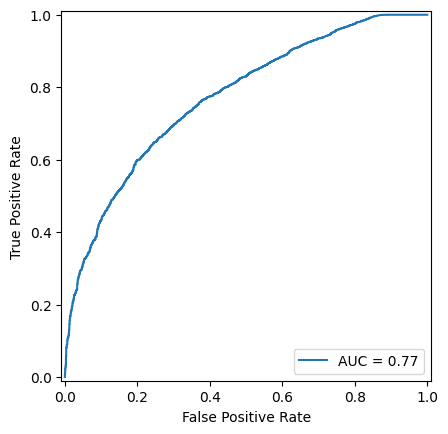

In [25]:
#calculate area under the curve
fpr, tpr, threshold = roc_curve(bnpl_tar_test, (bnpl_rf.predict_proba(bnpl_att_test)[:, 1]), pos_label='solvent')

bnpl_rf_roc_auc = auc(fpr, tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=bnpl_rf_roc_auc)
display.plot()

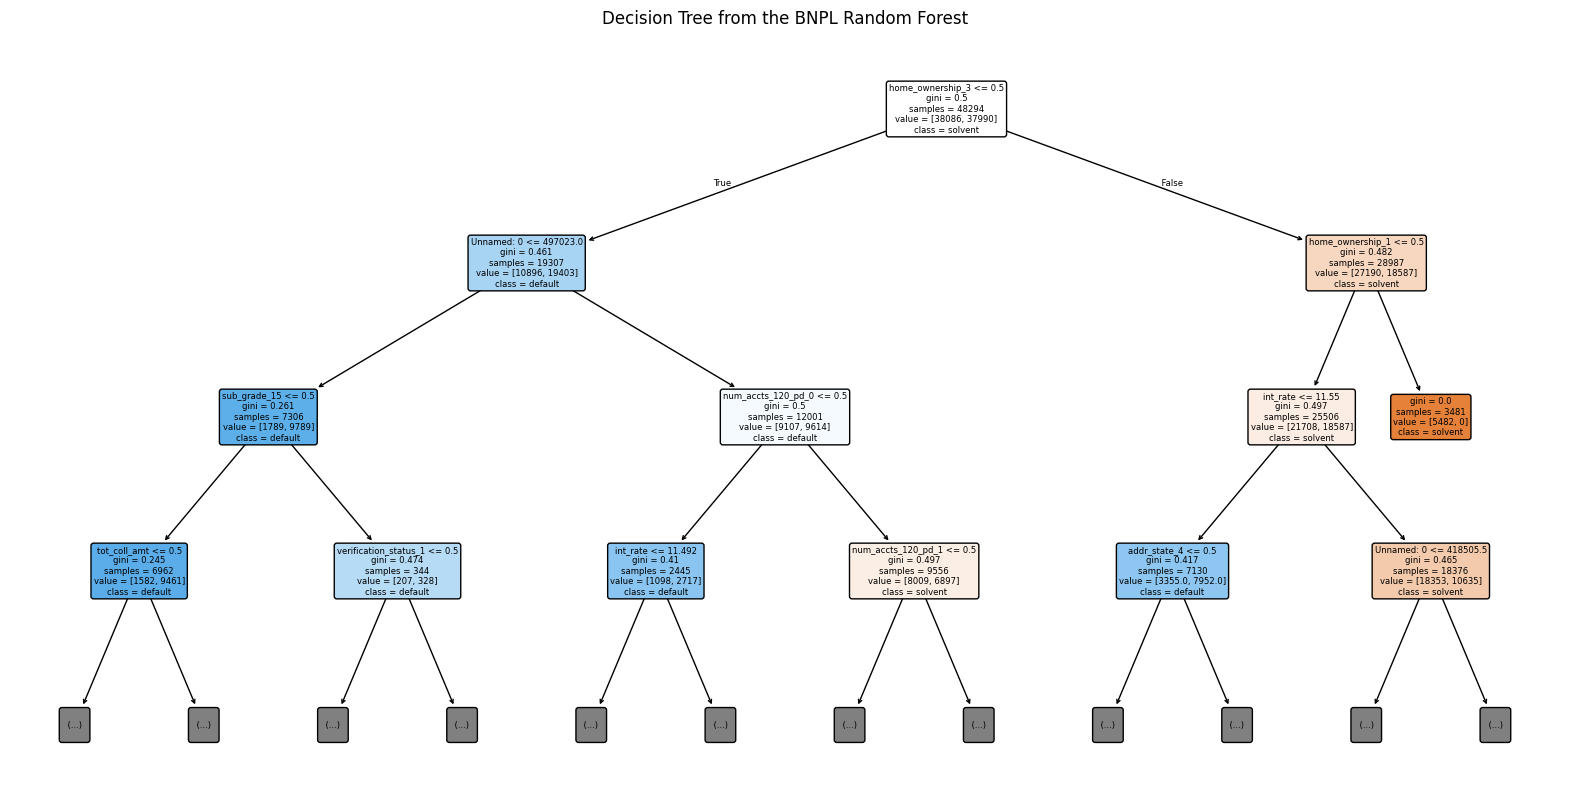

In [26]:
#Visualize a tree from the random forest to investigate splitting features

# capture feature names and target class for ease of use
features = bnpl_train_att_resample.columns
target = 'loan_status'
class_names = ['solvent', 'default']

#plot the tree
tree_rf_smote = bnpl_rf.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(tree_rf_smote,
          feature_names=features,
          class_names=class_names,
          filled=True,
          rounded=True,
          max_depth = 3)  #limit max depth otherwise text too small to read
plt.title("Decision Tree from the BNPL Random Forest")
plt.show()

# Repeat with K means SMOTE

In [27]:
#develop a Random Forest Model with KMSMOTE

bnpl_rf_KM = RandomForestClassifier(max_features=50, max_depth=5, random_state=0, n_estimators=100)

bnpl_rf_KM.fit(bnpl_train_att_KM_resample, bnpl_train_tar_KM_resample)
bnpl_rf_KM.predict(bnpl_train_att_KM_resample)
print("Accuracy:", bnpl_rf_KM.score(bnpl_att_test, bnpl_tar_test))

Accuracy: 0.8520546398735607


[[35920  2127]
 [ 4173 33865]]


<Figure size 18000x18000 with 0 Axes>

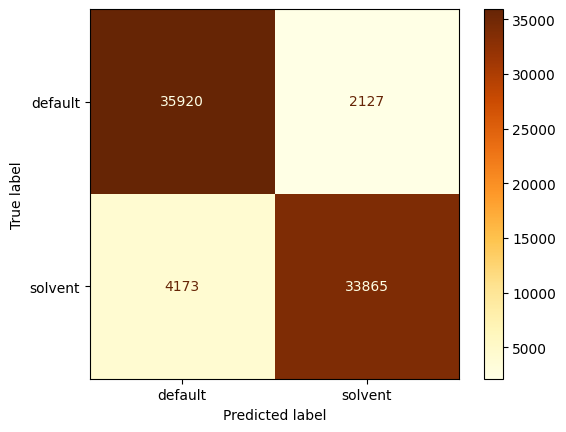

In [29]:
#develop a graphic to plot random forest KM

target_labels_KM = bnpl_rf_KM.predict(bnpl_train_att_KM_resample)
bnpl_KM_conmatx = confusion_matrix(bnpl_train_tar_KM_resample, target_labels_KM)
print(bnpl_KM_conmatx)

#plot
plt.figure(figsize = (60,60), dpi = 300)
disp = ConfusionMatrixDisplay(confusion_matrix = bnpl_KM_conmatx, display_labels=bnpl_rf_KM.classes_)
disp.plot(cmap="YlOrBr")
plt.show()

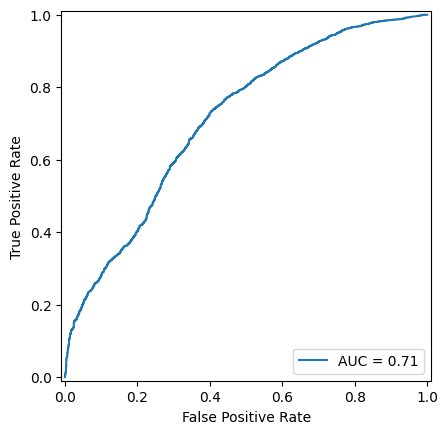

In [31]:
#calculate area under the curve
fpr, tpr, threshold = roc_curve(bnpl_tar_test, (bnpl_rf_KM.predict_proba(bnpl_att_test)[:, 1]), pos_label='solvent')

bnpl_rf_roc_auc = auc(fpr, tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=bnpl_rf_roc_auc)
display.plot()

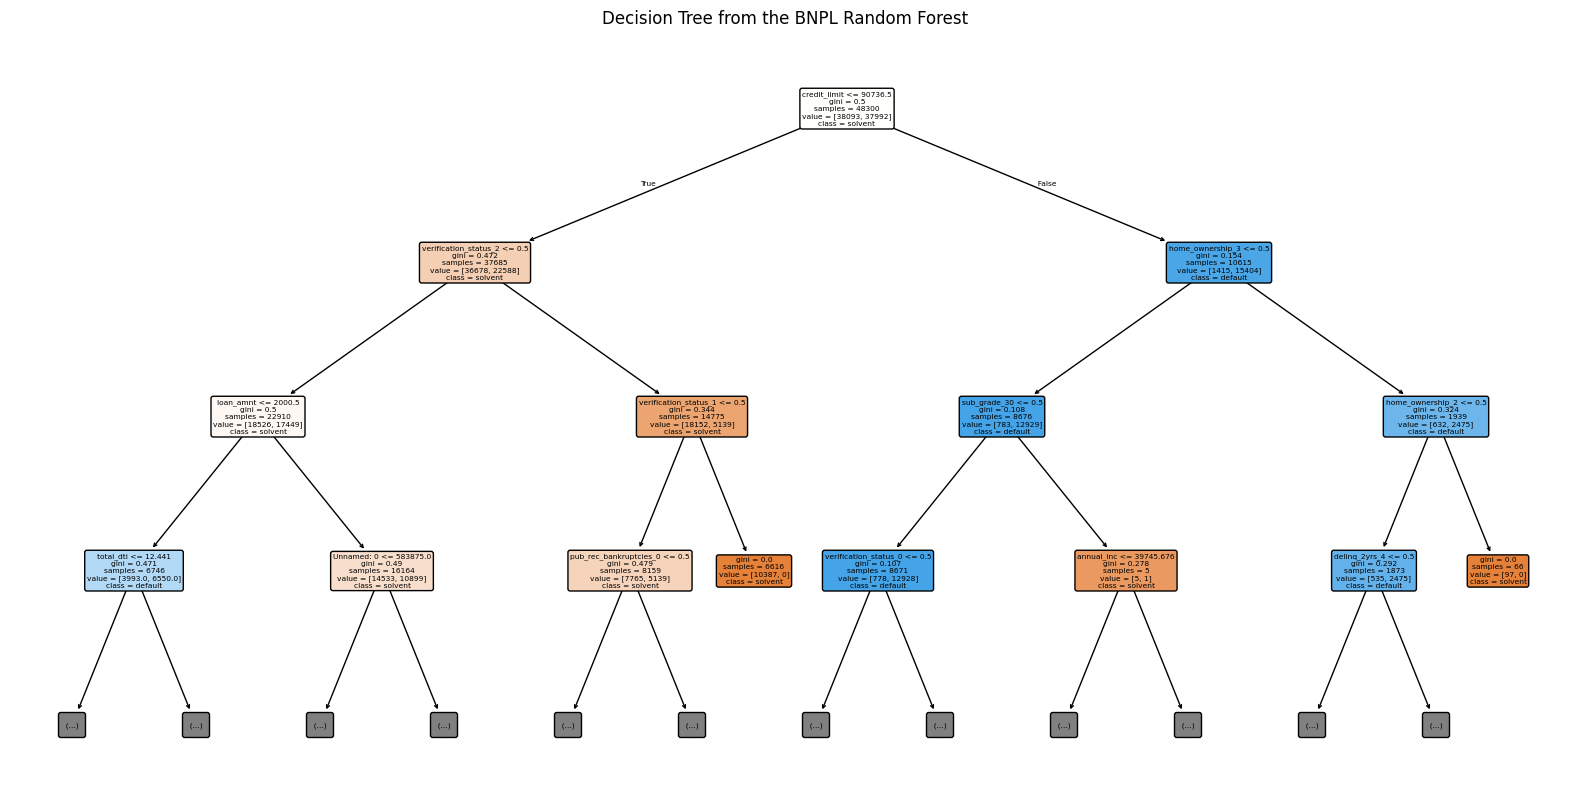

In [32]:
#Visualize a tree from the random forest to investigate splitting features

#plot the tree
tree_rf_KM = bnpl_rf_KM.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(tree_rf_KM,
          feature_names=features,
          class_names=class_names,
          filled=True,
          rounded=True,
          max_depth = 3) #limit the depth so text can be read
plt.title("Decision Tree from the BNPL Random Forest")
plt.show()